<a href="https://colab.research.google.com/github/sampath9dasari/Adversarial-Machine-Learning/blob/master/Evading_ML_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evading SVMs

In this section we will be training an SVM (support vector machine) to distinguish between the digits 0 and 1. The data is coming from the MNIST dataset which contains handwritten digits. We will be using `scikit-learn` to train our SVM. 

First let's start out by importing a few essentials.

In [0]:
from sklearn import svm
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.datasets import mnist
import random

Since we are only interested in the 1s and 0s in the data, we will need to pick those out. Since we need to this for both the test and training data, let's write a function for it.

This function does a few other things as well. 
- It normalizes the data, bringing it into the interval [0,1]
- It is also only using part of the data to make things a bit faster
- It changes the label to -1 and 1



In [0]:
def exract_two_classes( data, labels, classes=(0,1), no_instance=200 ):
  """
  Extract the desired number of instances of given classes from from the `data`.
  The function quantizes the data so that all values are in the interval [0,1]. 
  The returned lables are either -1 or 1. 

  data: numpy array of instances
  labels: numpy array of the labels
  classes: tuple of the the two class labels to be extracted
  no_instances: number of instances that are returned per class

  returns:
  x: np array of the instances of both class. The size of the first axis is
  no_instance * 2
  y: np array containing the labels for the instances in x. the labels have been 
  transformed so that it is -1 for instances of `classes[0]` and 1 for instances
  of `classes[1]`

  """
  data = data/255
  X0 = data[labels==classes[0]]
  random.shuffle(X0)
  X0 = X0[0:no_instance]
  X1 = data[labels==classes[1]]
  random.shuffle(X1)
  X1 = X1[0:no_instance]

  x = np.append(X0,X1,axis=0)
  y = np.append(np.ones(no_instance)*-1,np.ones(no_instance),axis=0)
  # pass
  return x, y

Next we need to load the data and spilt it into training and testing sets.

In [0]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [0]:
# extract two classes using the function we wrote earlier
x_train, y_train = exract_two_classes( x_train, y_train, classes=(0,1) )
x_test, y_test = exract_two_classes( x_test, y_test, classes=(0,1) )

We are going to define a SVM with a RBF (radial basis function) kernel and train it. 
Once training is done we are going to print the accuracy and show one of the images.

(400, 784)
accuracy on test set: 1.0


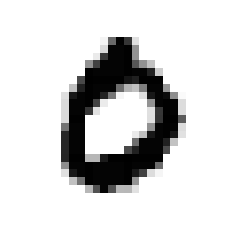

In [0]:
clf = svm.SVC( )

# each innstance needs to be 1 dimensional array. 
# transform that data:
x_train = x_train.reshape( ( x_train.shape[ 0 ], -1 ) )
x_test = x_test.reshape( ( x_test.shape[ 0 ], -1 ) )

print(x_train.shape)

clf.fit( x_train, y_train )
print( 'accuracy on test set:', clf.score( x_test, y_test ) )

# plot the first instance in the traning set
plt.imshow( x_test[ 0 ].reshape( 28, 28 ), cmap="gray_r" )
plt.axis( 'off' )
plt.show( )

Let's try evading the classifier by hand. Make some changes to sample of your choice. You can either change specific pixels or look into `np.random` for some options to make random changes to the image. Check the output of the classifier for your new sample

output before changes


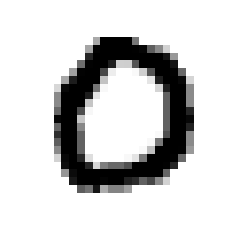

prediction before changes: [-1.]
output after changes


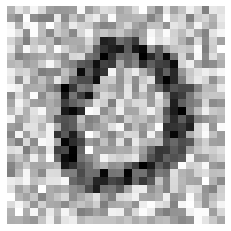

prediction after changes: [-1.]


In [0]:
# take sample and print some info on it
sample = x_test[ 7 ]


print('output before changes')
plt.imshow(sample.reshape( 28, 28 ), cmap="gray_r")
plt.axis( 'off' )
plt.show( )

# prediction before changes:
print( 'prediction before changes:', clf.predict( [ sample ] ))




###
sample = sample + np.random.rand(784)
###

print( 'output after changes' )
plt.imshow( sample.reshape( 28, 28 ), cmap="gray_r" )
plt.axis( 'off' )
plt.show( )

# prediction before changes
print( 'prediction after changes:', clf.predict( [ sample ] ))




To evade the classifier, we first pick a sample that we want to change. After that we need to retrieve some of the parameters of the SVM which we will need to calculate the gradients.

class prediction for the test samples: [1.]


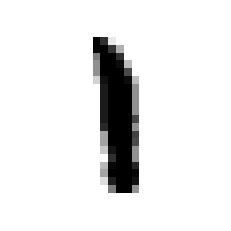

In [0]:
# constructing adversarial examples
sample = x_test[ 350 ]
print( 'class prediction for the test samples:', clf.predict( [ sample ] ) )

# Retrieve the internal parameters from the SVM
alpha = clf.dual_coef_
svs = clf.support_vectors_
nsv = svs.shape[ 0 ]
b = clf.intercept_
gamma = clf.degree

plt.imshow( sample.reshape( 28, 28 ), cmap="gray_r" )
plt.axis( 'off' )
plt.show( )

In [0]:
k = np.exp(-1*gamma*np.add.reduce((sample-mod_sample)**2))*(mod_sample-sample)
k.shape

(784,)

In [0]:
svs.shape

(55, 784)

Now that we have the internal parameters we can calcuate the gradients of the SVM and apply the modifications to our selected sample.

The strenght of the modifiction is controlled by the `lmbda` parameter. 
Modifications are applied iterativley controlled by the `iterations` parameter.

Make sure that the modified sample is in the interval [0,1]


Try to write the code make as little change as possible.

Once you have a solution that does not make unnecessary changes. Try different number pairs. 1 and 0 are pretty distinct. Try more and less distinct pairs. How does the behaviour change?



class prediction for the original sample: [1.]
class prediction for the modified sample: [1.]
original sample:


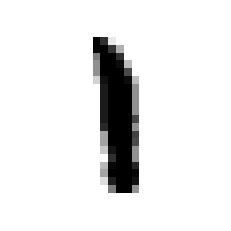

modified sample:


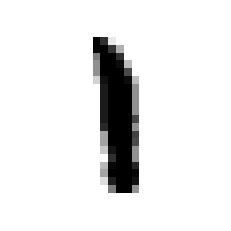

difference between the tow samples:


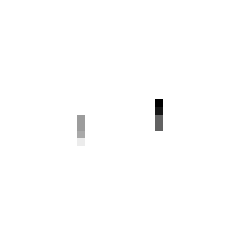

In [0]:
# the sample we modify
mod_sample = sample

# lambda, strength of the modification
lmbd = .01
alpha = alpha.reshape(55,)
g= np.array(np.zeros(svs.shape))
# Compute the gradient and modifiy the sample
for i in range(len(svs)):
  g[i,:] = 2*gamma*np.exp(-1*gamma*np.add.reduce((svs[i]-mod_sample)**2))*(svs[i]-mod_sample)

mod = -1*np.dot(alpha,g)

mod_sample = mod_sample + lmbd*mod
mod_sample = np.clip( mod_sample, 0., 1. )
print( 'class prediction for the original sample:', clf.predict( [sample] ) )
print( 'class prediction for the modified sample:', clf.predict( [mod_sample] ) )
print( 'original sample:')
plt.imshow( sample.reshape( 28, 28 ), cmap="gray_r" )
plt.axis( 'off' )
plt.show( )
print( 'modified sample:')
plt.imshow( mod_sample.reshape( 28, 28 ), cmap="gray_r" )
plt.axis( 'off' )
plt.show( )


print( 'difference between the tow samples:')
plt.imshow( np.abs(sample-mod_sample).reshape( 28, 28 ), cmap="gray_r" )
plt.axis( 'off' )
plt.show( )